#Project Milestone - Feature Learning for Video Feedback
##Victor Shepardson, Dartmouth College Digital Musics

The goal of this project is to discover aesthetically interesting digital video feedback processes by incorporating learned features into a hand constructed feedback process.

Consider a video feedback process defined by the mapping from images to images $x_t = \Delta_\phi(x_{t-1})$, where $\Delta$ is a transition function, $\phi$ is a parameterization which may be spatially varying or interactively controlled, and $x_t$ is the image at time step $t$.

Additionally suppose we have a deep autoencoder $\gamma$ for images: $$h^{\ell+1} = \gamma_\ell(h^\ell)$$ $$h^{\ell} \approx \gamma_\ell^{-1}(\gamma_\ell(h^\ell))$$ $$h^0 = x$$

Combining these two concepts, we can define a new feedback process where position in the feature hierarchy acts like another spatial dimension:
$$h_t^\ell = \Delta_\phi( h_{t-1}^\ell, \gamma_{\ell-1}(h_{t-1}^{l-1}), \gamma_\ell^{-1}(h_{t-1}^{\ell+1}) )$$

The goal then is to learn a deep autoencoder which represents abstract image features and admits layer-wise encoding and decoding as above. I propose a convolutional pooling autoencoder based on the convolutional autoencoders of [Masci et al.][1] and the upsampling layers of [Long et al.][2].

Below I have trained a single layer pooled convolutional autoencoder on the CIFAR-10 dataset using [caffe][3]. The code is available at my [GitHub](https://github.com/victor-shepardson/feature-feedback). I use a filter size of 3x3x3 and 2x2 max pooling. For this experiment, the data dimensionality is preserved in the intermediate representation by using 12 filters (3 input colors x factor of 4 lost to pooling). I trained on the L2 reconstruction error with momentum but no other regularization. Test error was found to decrease consistently from about 100 at random initialization to about 1.3.

[1]: http://people.idsia.ch/~masci/papers/2011_icann.pdf "Masci, J., Meier, U., Cireşan, D., & Schmidhuber, J. (2011). Stacked convolutional auto-encoders for hierarchical feature extraction. In Artificial Neural Networks and Machine Learning–ICANN 2011 (pp. 52-59). Springer Berlin Heidelberg."

[2]: http://arxiv.org/pdf/1411.4038v1.pdf "Long, J., Shelhamer, E., & Darrell, T. (2014). Fully convolutional networks for semantic segmentation. arXiv preprint arXiv:1411.4038."

[3]: http://caffe.berkeleyvision.org/ "Caffe Deep learning framework by the BVLC"


In [53]:
#get caffe and pycaffe set up

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#assuming feature-feedback repo and caffe root are in the same directory
caffe_root = '../../caffe/'
import sys
sys.path.insert(0, caffe_root+'python')

import caffe
from caffe.proto import caffe_pb2
#I have compiled caffe for CPU only (nvidia GPUs only)
caffe.set_mode_cpu()

In [3]:
#run this cell to solve the model defined in the solver_file
solver_file = 'autoencoder-0-solver.prototxt'
solver = caffe.get_solver(solver_file);
solver.solve();

In [151]:
#load the model trained by the previous cell
#(and saved elsewhere in the repo) and set it up on test data
model_def_file = 'autoencoder-0.prototxt'
model_file = '../bin/cifar-tanh-20epoch-unregularized.caffemodel'
net = caffe.Net(model_def_file, model_file, caffe.TEST)
#run a batch
net.forward()

{'l2_error': array(1.4730193614959717, dtype=float32)}

# Visualize Reconstruction
We can pull inputs and reconstructions straight out of the caffe Net and manually undo the mean subtraction:

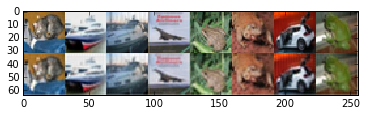

In [155]:
n = 8
blob = caffe_pb2.BlobProto()
data = open('../../caffe/examples/cifar10/mean.binaryproto').read()
blob.ParseFromString(data)
mean = caffe.io.blobproto_to_array(blob)[0].transpose([1,2,0])/256
inputs = np.hstack([ np.copy(net.blobs['data'].data[i]).transpose([1,2,0])+mean for i in range(n)])
outputs = np.hstack([ np.copy(net.blobs['decode1neuron'].data[i]).transpose([1,2,0])+mean for i in range(n)])
#clamp the reconstruction to [0,1]
#even with tanh activation outputs can be out of bounds once mean is added back
np.clip(outputs, 0, 1, outputs)
disp = np.vstack((inputs,outputs))
plt.imshow(disp, interpolation='None')

 CIFAR-10 test inputs on top, reconstructions on the bottom. Looks good!

#Visualize Filters

Now let's pull our 12 3x3x3 filters out of the model

[-0.36862749 -0.1923824  -0.22088723 -0.12164118 -0.10508166 -0.49331141
 -0.53125817 -0.48567948 -0.44001433 -0.39040077 -0.32423615 -0.1737113 ]


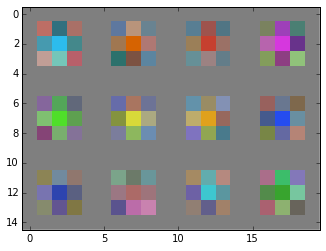

In [154]:
filters = np.copy(net.params['encode1'][0].data).transpose([0,2,3,1])
#print filters
biases = np.copy(net.params['encode1'][1].data)
print biases
#normalize preserving 0 = 50% gray
filters/=2*abs(filters).max()
filters+=.5
disp = np.hstack([np.pad(f,[(1,1),(1,1),(0,0)],'constant', constant_values=[.5]) for f in filters])
disp = np.vstack(np.hsplit(disp,3))
plt.imshow(disp, interpolation='none')

Looks like the network mostly learned localized primary and secondary color detectors. Weird! These aren't the usual edge filters, but they seem to at least have some plausible structure.

#Visualize filter responses

Now let's see the (max pooled) reponses of all 12 filters to a few inputs: 

(192, 128, 1)


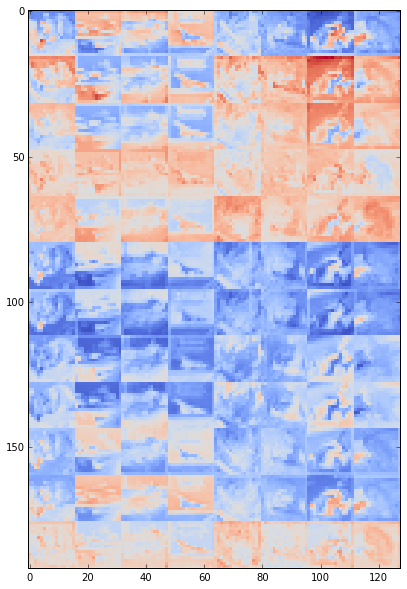

In [156]:
n=8
reps = np.hstack([ net.blobs['pool1'].data[i].transpose([1,2,0]) for i in range(n)])
# normalize preserving 0 = 50% gray
reps/=2*abs(reps).max()
reps+=.5
reps = np.vstack(np.dsplit(reps, 12))
print reps.shape
plt.figure(figsize=(10,10))
plt.imshow(reps.squeeze(), interpolation='none', cmap='coolwarm')

Pooled activations for each of 12 filters. Red is positive response, blue negative.

#Further Work

It's hard to say from this small experiment whether the autoencoder is learning meaningful features. The next thing to do will be to scale up to larger images and deeper networks. Once I have trained an autoencoder to produce reasonable features, I'll reimplement it with OpenGL and openFrameworks and work on $\Delta$.